In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/word2vec/GoogleNews-vectors-negative300.bin
/kaggle/input/amazon-fine-food-reviews/database.sqlite
/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazonfinefood-dl/TestTextPrep.csv
/kaggle/input/amazonfinefood-dl/__results__.html
/kaggle/input/amazonfinefood-dl/NormalizeCleandf.csv
/kaggle/input/amazonfinefood-dl/__output__.json
/kaggle/input/amazonfinefood-dl/custom.css
/kaggle/input/amazonfinefood-dl/XTrain.npy
/kaggle/input/amazonfinefood-dl/__notebook__.ipynb
/kaggle/input/amazonfinefood-dl/YTest.npy
/kaggle/input/amazonfinefood-dl/BinaryDatadf.csv
/kaggle/input/amazonfinefood-dl/YTrain.npy
/kaggle/input/amazonfinefood-dl/TrainTextPrep.csv
/kaggle/input/amazonfinefood-dl/word2vec_embedding_weights.npy
/kaggle/input/amazonfinefood-dl/FilteredRatedf.csv
/kaggle/input/amazonfinefood-dl/XTest.npy
/kaggle/input/amazonfinefood-dl/__results___files/__results___11_0.png


In [2]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import re
from bs4 import BeautifulSoup
from tqdm import tqdm

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from gensim.models import KeyedVectors

from tensorflow.keras.layers import Embedding, Input, LSTM, Dense, GlobalAveragePooling1D, Dropout, Bidirectional
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# f1_score
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

import tensorflow as tf
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [3]:
import pandas as pd 
df = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")
print("Size of the data is, ", df.shape)
df.head()


Size of the data is,  (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.info() # no null info, no need to fill 비워진 값 확인 과정

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


# > **중복없애기 Dropping Duplicates** 

In [5]:
df=df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print("Size of the data after dropping duplicates, ", df.shape)

Size of the data after dropping duplicates,  (393933, 10)


In [6]:
# Reshape it with only needed elements
# 필요한 요소들로만 다시 구성
df=df[['ProductId','Summary','Text','Score']]
df['ProductId'] = df['ProductId']
df['Summary Of Review'] = df['Summary']
df['General Review'] = df['Text']
df['Rate'] = df['Score']
df.drop(['ProductId','Summary','Text','Score'],axis=1,inplace=True)
print("Size of the data after drop for only necessary elements, ", df.shape)
df.head()

Size of the data after drop for only necessary elements,  (393933, 3)


,Summary Of Review,General Review,Rate
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,5
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1
2,"""Delight"" says it all",This is a confection that has been around a fe...,4
3,Cough Medicine,If you are looking for the secret ingredient i...,2
4,Great taffy,Great taffy at a great price. There was a wid...,5


In [7]:
df_filter = df[df["Rate"]!=3].copy() # Filter so the rate 3 data does not exist 점수3 제거 과정
print("Size of data after filtering Score 3, ",df_filter.shape)
df.head()
df_filter.to_csv('FilteredRatedf.csv',index=False)

Size of data after filtering Score 3,  (364164, 3)


In [8]:
df_filter['General Review'] = df_filter['Summary Of Review']+ " " + df_filter['General Review'] # Summary 와 Review 를 합친 것
df_filter.drop(['Summary Of Review'],axis=1,inplace=True)
df_filter.head()

,General Review,Rate
0,Good Quality Dog Food I have bought several of...,5
1,Not as Advertised Product arrived labeled as J...,1
2,"""Delight"" says it all This is a confection tha...",4
3,Cough Medicine If you are looking for the secr...,2
4,Great taffy Great taffy at a great price. The...,5


# > **Binary로 표현 바꾸기 (sentiments of 0 and 1)** 

In [9]:
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

df_filter["Binary_Identify"]  = df_filter["Rate"].apply(lambda x : 1 if x > 3 else 0)
df_filter.drop(['Rate'],axis=1,inplace=True)
print("Ratio of 0 and 1 as for Binary_Identification, ") 
print(df_filter["Binary_Identify"].value_counts(normalize=True))
df_filter.head()
df_filter.to_csv('BinaryDatadf.csv',index=False)

Ratio of 0 and 1 as for Binary_Identification, 
1    0.843181
0    0.156819
Name: Binary_Identify, dtype: float64


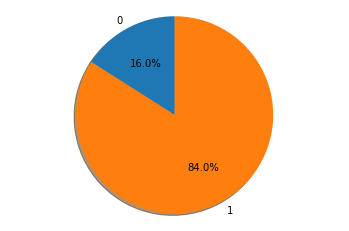

In [10]:
#Visualization of data
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Pie chart to check the estimated ratio of sentiments(0 or 1)
labels = '0', '1'
sizes = [16,84]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


# > **정제,정규화 Cleaning Texts, Normalization** 

In [11]:
#Tokenization for preprocessing text
import re
from bs4 import BeautifulSoup
from tqdm import tqdm

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def apostrophe_correction(text):
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

def text_preprocess(g_review):
    g_review = re.sub(r"http\S+", "", g_review)             # removing website links
    g_review = BeautifulSoup(g_review, 'lxml').get_text()   # removing html tags
    g_review = apostrophe_correction(g_review)              # for the exceptions (tokenization)
    
    g_review = re.sub("\S*\d\S*", "", g_review).strip()     # removing the words with numeric digits
    g_review = re.sub('[^A-Za-z]+', ' ', g_review)          # removing non-word characters
    g_review = re.sub(r'\W*\b\w{1,2}\b','', g_review)       # removing short words
    
    
    stop_words = set(stopwords.words('english')) 
    g_review = [word for word in g_review.split(" ") if not word in stop_words] # removing stop words
    
    lemmatizer = WordNetLemmatizer()
    g_review = [lemmatizer.lemmatize(token, "v") for token in g_review] # Lemmatization
    g_review = " ".join(g_review)
    g_review.strip()
    return g_review

In [12]:
df_filter

,General Review,Binary_Identify
0,Good Quality Dog Food I have bought several of...,1
1,Not as Advertised Product arrived labeled as J...,0
2,"""Delight"" says it all This is a confection tha...",1
3,Cough Medicine If you are looking for the secr...,0
4,Great taffy Great taffy at a great price. The...,1
...,...,...
568449,Will not do without Great for sesame chicken.....,1
568450,disappointed I'm disappointed with the flavor....,0
568451,Perfect for our maltipoo These stars are small...,1
568452,Favorite Training and reward treat These are t...,1


In [13]:
df_filter['General Review'] = df_filter['General Review'].astype(str)
df_filter['General Review'] = df_filter['General Review'].apply(lambda x: text_preprocess(x.lower())) # input after converting to lower case

In [14]:
df_filter.to_csv('NormalizeCleandf.csv',index=False)
print(df_filter['General Review'].shape)
print(df_filter['General Review'])

(364164,)
0         good quality dog food buy several vitality can...
1         advertise product arrive label jumbo salt pean...
2          delight say confection around centuries light...
3         cough medicine look secret ingredient robituss...
4         great taffy great taffy great price wide assor...
                                ...                        
568449    without great sesame chicken good better restu...
568450    disappoint disappoint flavor chocolate note es...
568451    perfect maltipoo star small give one train ses...
568452    favorite train reward treat best treat train r...
568453    great honey satisfy product advertise use cere...
Name: General Review, Length: 364164, dtype: object


In [15]:
df_text_prep= pd.read_csv('/kaggle/input/amazonfinefood-dl/NormalizeCleandf.csv')

df_text_prep['General Review'] = df_text_prep['General Review'].astype(str).copy()

In [16]:
df_text_prep

,General Review,Binary_Identify
0,good quality dog food buy several vitality can...,1
1,advertise product arrive label jumbo salt pean...,0
2,delight say confection around centuries light...,1
3,cough medicine look secret ingredient robituss...,0
4,great taffy great taffy great price wide assor...,1
...,...,...
364159,without great sesame chicken good better restu...,1
364160,disappoint disappoint flavor chocolate note es...,0
364161,perfect maltipoo star small give one train ses...,1
364162,favorite train reward treat best treat train r...,1


# >데이터 분리(Splitting Data)

In [17]:
df_train, df_test = train_test_split(df_text_prep, test_size = 0.2, random_state = 100, shuffle =True, stratify=df_text_prep['Binary_Identify'])

df_train['Binary_Identify'] = df_train['Binary_Identify'].astype('int64')
df_train['General Review'] = df_train['General Review'].astype(str).copy()

In [18]:
df_train.to_csv('TrainTextPrep.csv', index = False)
df_test.to_csv('TestTextPrep.csv', index = False)

# > **텍스트에 인덱스부여 Integer Encoding** 

In [19]:
train_text_prep = pd.read_csv('/kaggle/input/amazonfinefood-dl/TrainTextPrep.csv')
test_text_prep = pd.read_csv('/kaggle/input/amazonfinefood-dl/TestTextPrep.csv')

train_text_prep['General Review'] = train_text_prep['General Review'].astype(str).copy()

In [20]:
from collections import Counter
upToward = 5500
tokenizer = Tokenizer(num_words=upToward)
tokenizer.fit_on_texts(df_text_prep['General Review'])
train_tokenized = tokenizer.texts_to_sequences(train_text_prep['General Review'])
test_tokenized = tokenizer.texts_to_sequences(test_text_prep['General Review'])

dictml = {}
sum = 0
max_lent = 0

for i in range(len(train_tokenized)):
    dictml[i] = len(train_tokenized[i])
    if len(train_tokenized[i]) > max_lent:
        max_lent = len(train_tokenized[i])        
        
res = Counter(dictml.values()) 
#key is length, value is number of padded having that length
res = dict(res)
res = sorted(res.items(), key=(lambda x: x[1]), reverse=True)
print(res)
#length가 140일 때의 padded가 100을 넘기고 그 후로는 100보다 작은 수의 count를 가지므로 140이 max length로 적합해보임

[(16, 9322), (15, 9300), (17, 9076), (14, 9070), (18, 8744), (19, 8555), (13, 8391), (20, 7965), (21, 7731), (22, 7496), (12, 7330), (23, 7107), (24, 6692), (25, 6526), (26, 6215), (11, 5993), (27, 5849), (28, 5691), (29, 5463), (30, 5294), (31, 4916), (32, 4903), (33, 4703), (10, 4449), (34, 4406), (35, 4335), (36, 4081), (38, 3755), (37, 3742), (39, 3620), (40, 3423), (41, 3328), (42, 3121), (43, 3027), (44, 2907), (45, 2746), (46, 2714), (9, 2701), (47, 2522), (48, 2449), (49, 2358), (50, 2257), (51, 2191), (52, 2025), (53, 1968), (54, 1959), (55, 1844), (57, 1776), (56, 1716), (58, 1658), (60, 1533), (59, 1530), (8, 1476), (62, 1475), (61, 1415), (63, 1360), (64, 1297), (65, 1275), (66, 1238), (67, 1187), (69, 1128), (68, 1089), (70, 1076), (71, 1003), (72, 969), (73, 949), (74, 903), (75, 848), (76, 821), (77, 764), (79, 740), (81, 731), (78, 719), (7, 714), (80, 709), (83, 661), (84, 648), (82, 617), (85, 605), (86, 584), (88, 567), (87, 544), (90, 511), (89, 500), (91, 491), (94

 # > **제로패딩 Zero Padding** 

In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 140
x_train = pad_sequences(train_tokenized, maxlen=max_length, padding = 'post')
y_train = train_text_prep['Binary_Identify']


In [22]:
np.save('XTrain.npy', x_train)
np.save('YTrain.npy', y_train)

In [23]:
test_tokenized = tokenizer.texts_to_sequences(test_text_prep['General Review'])
x_test = pad_sequences(test_tokenized, maxlen=max_length, padding= 'post')
y_test = test_text_prep['Binary_Identify']

In [24]:
np.save('XTest.npy', x_test)
np.save('YTest.npy', y_test)

# > Pretrained Embedding(Word2vec)

In [25]:
## Pretrained Embedding: Word2Vec
word2vec = KeyedVectors.load_word2vec_format("/kaggle/input/word2vec/GoogleNews-vectors-negative300.bin", binary=True)

VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# tokenizer에 있는 단어 사전을 순회하면서 word2vec의 300차원 vector를 가져옵니다
for word, idx in tokenizer.word_index.items():
    embedding_vector = word2vec[word] if word in word2vec else None
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        
np.save("word2vec_embedding_weights.npy", embedding_matrix)
embedding_matrix.shape

(110315, 300)

In [26]:
# 여기서부터 다시 돌리면 됩니다

word2vec_embedding = np.load('/kaggle/input/amazonfinefood-dl/word2vec_embedding_weights.npy')

# > Random Embedding(keras.layers.Embedding)

In [27]:
vocab_size = max(np.unique(x_train)) + 1 # 단어집합 크기

max_len = 0
for i in range(291331):
    if len(x_train[i]) > max_len:
        max_len = len(x_train[i])
print('padded된 행의 max_len 값 :', max_len)# index된 문장의 max length = padding된 length

print('단어 집합의 크기 :', vocab_size)
batch_size = len(x_train[:,0]) # padded의 행 개수
print('padded의 행 개수 :', batch_size)
ebd_dim = 300 # embedding 후 vector의 dimension

VOCAB_SIZE = len(tokenizer.word_index) + 1

padded된 행의 max_len 값 : 140
단어 집합의 크기 : 5500
padded의 행 개수 : 291331


# >Building Model

In [28]:
X_train = np.load('/kaggle/input/amazonfinefood-dl/XTrain.npy')
Y_train = np.load('/kaggle/input/amazonfinefood-dl/YTrain.npy')
X_test = np.load('/kaggle/input/amazonfinefood-dl/XTest.npy')
Y_test = np.load('/kaggle/input/amazonfinefood-dl/YTest.npy')

In [29]:
# 
with tpu_strategy.scope():
    model = tf.keras.Sequential() # define your model normally
    model.add(Embedding(upToward, ebd_dim, input_length=max_len, embeddings_initializer='uniform',mask_zero=True))
    model.add(LSTM(128))
    model.add(Dense(1,activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy', recall_m, precision_m, f1_m])
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 300)          1650000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,869,777
Trainable params: 1,869,777
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Word2Vec
with tpu_strategy.scope():
    model1 = tf.keras.Sequential()
    model1.add(Embedding(VOCAB_SIZE, 
                    ebd_dim, 
                    input_length=max_length, 
                    weights=[word2vec_embedding], # weight는 바로 위의 embedding_matrix 대입
                    trainable=False , # embedding layer에 대한 train은 꼭 false로 지정
                    embeddings_initializer='uniform',mask_zero=True)
             )
    model1.add(LSTM(128))
    model1.add(Dense(1,activation = 'sigmoid'))
    model1.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy', recall_m, precision_m, f1_m])
    model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 300)          33094500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 33,314,277
Trainable params: 219,777
Non-trainable params: 33,094,500
_________________________________________________________________


In [31]:
# Bidirection, L2 reg
with tpu_strategy.scope():
    model2 = tf.keras.Sequential()
    model2.add(Embedding(upToward, ebd_dim, input_length=max_len, embeddings_initializer='uniform',mask_zero=True))
    
    model2.add(Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1)))
    model2.add(Bidirectional(LSTM(units=50)))
    model2.add(Dense(6,'relu', kernel_regularizer=regularizers.l2(0.001)))
    model2.add(Dense(1,activation = 'sigmoid'))
    model2.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy', recall_m, precision_m, f1_m])
    model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 140, 300)          1650000   
_________________________________________________________________
bidirectional (Bidirectional (None, 140, 100)          140400    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 1,851,413
Trainable params: 1,851,413
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Word2Vec, Bidirection
with tpu_strategy.scope():
    model3 = tf.keras.Sequential()
    model3.add(Embedding(VOCAB_SIZE, 
                    ebd_dim, 
                    input_length=max_length, 
                    weights=[word2vec_embedding],
                    trainable=False , # embedding layer에 대한 train은 꼭 false로 지정
                    embeddings_initializer='uniform',mask_zero=True)
             )
    model3.add(Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1)))
    model3.add(Bidirectional(LSTM(units=50)))
    model3.add(Dense(1,activation = 'sigmoid'))
    model3.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy', recall_m, precision_m, f1_m])
    model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 140, 300)          33094500  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 140, 100)          140400    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 33,295,401
Trainable params: 200,901
Non-trainable params: 33,094,500
_________________________________________________________________


In [33]:
# L2 reg
with tpu_strategy.scope():
    model4 = tf.keras.Sequential()
    model4.add(Embedding(upToward, ebd_dim, input_length=max_len, embeddings_initializer='uniform',mask_zero=True))
    model4.add(LSTM(128))
    model4.add(Dense(1,activation = 'sigmoid',kernel_regularizer=regularizers.l2(0.001)))
    model4.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy', recall_m, precision_m, f1_m])
    model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 140, 300)          1650000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,869,777
Trainable params: 1,869,777
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Bidirection
with tpu_strategy.scope():
    model5 = tf.keras.Sequential() # define your model normally
    model5.add(Embedding(upToward, ebd_dim, input_length=max_len, embeddings_initializer='uniform',mask_zero=True))
    model5.add(Bidirectional(LSTM(units =50, return_sequences = True, recurrent_dropout=0.1)))
    model5.add(Bidirectional(LSTM(50)))
    model5.add(Dense(1,activation = 'sigmoid'))
    model5.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy', recall_m, precision_m, f1_m])
    model5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 140, 300)          1650000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 140, 100)          140400    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 1,850,901
Trainable params: 1,850,901
Non-trainable params: 0
_________________________________________________________________


In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [36]:
# 
history = model.fit(X_train, Y_train, epochs=20, callbacks=[es,mc], batch_size=1024, validation_split=0.2)

Epoch 1/20
228/228 [==============================] - 12s 54ms/step - precision_m: 0.9322 - accuracy: 0.9134 - recall_m: 0.9705 - loss: 0.2266 - f1_m: 0.9496 - val_precision_m: 0.9448 - val_accuracy: 0.9358 - val_recall_m: 0.9813 - val_loss: 0.1616 - val_f1_m: 0.9625
Epoch 2/20
228/228 [==============================] - 8s 33ms/step - precision_m: 0.9580 - accuracy: 0.9429 - recall_m: 0.9751 - loss: 0.1484 - f1_m: 0.9663 - val_precision_m: 0.9596 - val_accuracy: 0.9389 - val_recall_m: 0.9683 - val_loss: 0.1562 - val_f1_m: 0.9638
Epoch 3/20
228/228 [==============================] - 7s 33ms/step - precision_m: 0.9616 - accuracy: 0.9469 - recall_m: 0.9759 - loss: 0.1365 - f1_m: 0.9686 - val_precision_m: 0.9597 - val_accuracy: 0.9416 - val_recall_m: 0.9715 - val_loss: 0.1489 - val_f1_m: 0.9654
Epoch 4/20
228/228 [==============================] - 7s 33ms/step - precision_m: 0.9652 - accuracy: 0.9511 - recall_m: 0.9773 - loss: 0.1252 - f1_m: 0.9711 - val_precision_m: 0.9552 - val_accuracy:

In [37]:
# 
history1 = model1.fit(X_train, Y_train, epochs=20, callbacks=[es,mc], batch_size=1024, validation_split=0.2)

Epoch 1/20
228/228 [==============================] - 10s 44ms/step - precision_m: 0.9085 - accuracy: 0.8888 - recall_m: 0.9679 - loss: 0.2735 - f1_m: 0.9361 - val_precision_m: 0.9454 - val_accuracy: 0.9148 - val_recall_m: 0.9541 - val_loss: 0.2044 - val_f1_m: 0.9495
Epoch 2/20
228/228 [==============================] - 7s 29ms/step - precision_m: 0.9394 - accuracy: 0.9216 - recall_m: 0.9696 - loss: 0.1965 - f1_m: 0.9540 - val_precision_m: 0.9537 - val_accuracy: 0.9245 - val_recall_m: 0.9569 - val_loss: 0.1862 - val_f1_m: 0.9551
Epoch 3/20
228/228 [==============================] - 7s 29ms/step - precision_m: 0.9459 - accuracy: 0.9297 - recall_m: 0.9724 - loss: 0.1785 - f1_m: 0.9587 - val_precision_m: 0.9523 - val_accuracy: 0.9316 - val_recall_m: 0.9673 - val_loss: 0.1702 - val_f1_m: 0.9596
Epoch 4/20
228/228 [==============================] - 7s 29ms/step - precision_m: 0.9502 - accuracy: 0.9341 - recall_m: 0.9730 - loss: 0.1672 - f1_m: 0.9612 - val_precision_m: 0.9472 - val_accuracy:

In [38]:
# 
history2 = model2.fit(X_train, Y_train, epochs=20, callbacks=[es,mc], batch_size=1024, validation_split=0.2)

Epoch 1/20
228/228 [==============================] - 21s 93ms/step - precision_m: 0.9378 - accuracy: 0.9206 - recall_m: 0.9725 - loss: 0.2123 - f1_m: 0.9538 - val_precision_m: 0.9550 - val_accuracy: 0.9416 - val_recall_m: 0.9768 - val_loss: 0.1547 - val_f1_m: 0.9656
Epoch 2/20
228/228 [==============================] - 13s 55ms/step - precision_m: 0.9611 - accuracy: 0.9462 - recall_m: 0.9757 - loss: 0.1439 - f1_m: 0.9682 - val_precision_m: 0.9621 - val_accuracy: 0.9436 - val_recall_m: 0.9714 - val_loss: 0.1480 - val_f1_m: 0.9666
Epoch 3/20
228/228 [==============================] - 13s 56ms/step - precision_m: 0.9656 - accuracy: 0.9515 - recall_m: 0.9774 - loss: 0.1289 - f1_m: 0.9713 - val_precision_m: 0.9606 - val_accuracy: 0.9439 - val_recall_m: 0.9734 - val_loss: 0.1468 - val_f1_m: 0.9668
Epoch 4/20
228/228 [==============================] - 13s 56ms/step - precision_m: 0.9695 - accuracy: 0.9567 - recall_m: 0.9794 - loss: 0.1160 - f1_m: 0.9743 - val_precision_m: 0.9611 - val_accura

In [39]:
# 
history3 = model3.fit(X_train, Y_train, epochs=20, callbacks=[es,mc], batch_size=1024, validation_split=0.2)

Epoch 1/20
228/228 [==============================] - 19s 82ms/step - precision_m: 0.9178 - accuracy: 0.8977 - recall_m: 0.9678 - loss: 0.2512 - f1_m: 0.9396 - val_precision_m: 0.9457 - val_accuracy: 0.9253 - val_recall_m: 0.9669 - val_loss: 0.1863 - val_f1_m: 0.9560
Epoch 2/20
228/228 [==============================] - 11s 50ms/step - precision_m: 0.9456 - accuracy: 0.9283 - recall_m: 0.9708 - loss: 0.1793 - f1_m: 0.9578 - val_precision_m: 0.9423 - val_accuracy: 0.9319 - val_recall_m: 0.9793 - val_loss: 0.1707 - val_f1_m: 0.9603
Epoch 3/20
228/228 [==============================] - 12s 51ms/step - precision_m: 0.9512 - accuracy: 0.9352 - recall_m: 0.9731 - loss: 0.1631 - f1_m: 0.9618 - val_precision_m: 0.9522 - val_accuracy: 0.9374 - val_recall_m: 0.9747 - val_loss: 0.1568 - val_f1_m: 0.9632
Epoch 4/20
228/228 [==============================] - 12s 51ms/step - precision_m: 0.9544 - accuracy: 0.9392 - recall_m: 0.9745 - loss: 0.1546 - f1_m: 0.9641 - val_precision_m: 0.9522 - val_accura

In [40]:
# 
history4 = model4.fit(X_train, Y_train, epochs=20, callbacks=[es,mc], batch_size=1024, validation_split=0.2)

Epoch 1/20
228/228 [==============================] - 13s 55ms/step - precision_m: 0.9334 - accuracy: 0.9148 - recall_m: 0.9704 - loss: 0.2243 - f1_m: 0.9503 - val_precision_m: 0.9531 - val_accuracy: 0.9377 - val_recall_m: 0.9741 - val_loss: 0.1651 - val_f1_m: 0.9633
Epoch 2/20
228/228 [==============================] - 8s 33ms/step - precision_m: 0.9582 - accuracy: 0.9432 - recall_m: 0.9752 - loss: 0.1499 - f1_m: 0.9664 - val_precision_m: 0.9559 - val_accuracy: 0.9416 - val_recall_m: 0.9758 - val_loss: 0.1532 - val_f1_m: 0.9656
Epoch 3/20
228/228 [==============================] - 8s 33ms/step - precision_m: 0.9615 - accuracy: 0.9473 - recall_m: 0.9767 - loss: 0.1379 - f1_m: 0.9689 - val_precision_m: 0.9579 - val_accuracy: 0.9407 - val_recall_m: 0.9725 - val_loss: 0.1525 - val_f1_m: 0.9650
Epoch 4/20
228/228 [==============================] - 8s 33ms/step - precision_m: 0.9644 - accuracy: 0.9509 - recall_m: 0.9779 - loss: 0.1281 - f1_m: 0.9710 - val_precision_m: 0.9641 - val_accuracy:

In [41]:
# 
history5 = model5.fit(X_train, Y_train, epochs=20, callbacks=[es,mc], batch_size=1024, validation_split=0.2)

Epoch 1/20
228/228 [==============================] - 21s 94ms/step - precision_m: 0.9381 - accuracy: 0.9214 - recall_m: 0.9731 - loss: 0.2019 - f1_m: 0.9542 - val_precision_m: 0.9572 - val_accuracy: 0.9411 - val_recall_m: 0.9736 - val_loss: 0.1499 - val_f1_m: 0.9652
Epoch 2/20
228/228 [==============================] - 13s 55ms/step - precision_m: 0.9605 - accuracy: 0.9457 - recall_m: 0.9758 - loss: 0.1394 - f1_m: 0.9679 - val_precision_m: 0.9613 - val_accuracy: 0.9435 - val_recall_m: 0.9721 - val_loss: 0.1450 - val_f1_m: 0.9665
Epoch 3/20
228/228 [==============================] - 13s 56ms/step - precision_m: 0.9653 - accuracy: 0.9516 - recall_m: 0.9778 - loss: 0.1254 - f1_m: 0.9714 - val_precision_m: 0.9618 - val_accuracy: 0.9427 - val_recall_m: 0.9705 - val_loss: 0.1468 - val_f1_m: 0.9660
Epoch 4/20
228/228 [==============================] - 13s 56ms/step - precision_m: 0.9695 - accuracy: 0.9573 - recall_m: 0.9802 - loss: 0.1120 - f1_m: 0.9747 - val_precision_m: 0.9611 - val_accura

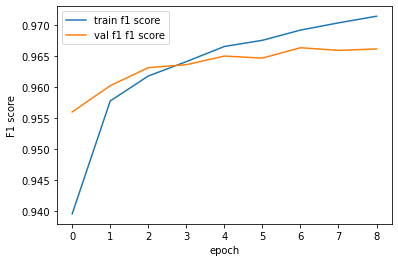

In [42]:
plt.plot(history3.history['f1_m'], label='train f1 score')
plt.plot(history3.history['val_f1_m'], label='val f1 f1 score')
plt.xlabel("epoch")
plt.ylabel("F1 score")
plt.legend() ;

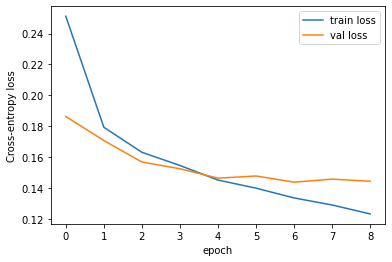

In [43]:
plt.plot(history3.history['loss'], label='train loss')
plt.plot(history3.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend() ;

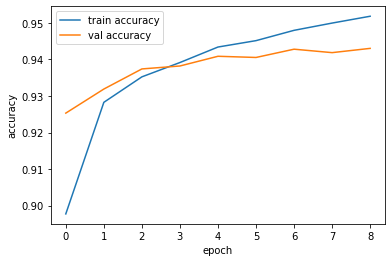

In [44]:
plt.plot(history3.history['accuracy'], label='train accuracy')
plt.plot(history3.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [45]:
print("Evaluate on test data")
test_loss, test_acc,test_recall, test_precision, test_f1 = model3.evaluate(X_test, Y_test, batch_size =1024, verbose=1)
#test data 모델 평가 (모델 3 적용)
print("test loss :", test_loss)
print("test accuracy :", test_acc)
print("test recall :", test_recall)
print('test precision :', test_precision)
print('test f1 score :', test_f1)

Evaluate on test data
72/72 [==============================] - 2s 32ms/step - precision_m: 0.9627 - accuracy: 0.9450 - recall_m: 0.9719 - loss: 0.1437 - f1_m: 0.9670
test loss : 0.1436646282672882
test accuracy : 0.9450111985206604
test recall : 0.9718942642211914
test precision : 0.9627060294151306
test f1 score : 0.9670298099517822


In [46]:
final_output = pd.DataFrame(columns=["Model #", "Constructure", "Train_Val_Loss", "Train_Val_Acc", "F1_Val"])
final_output = final_output.append({"Model #": 1,
                                    "Constructure": 'Word2vec', 
                                    "Train_Val_Loss": '{:.5f}'.format(history1.history['val_loss'][10]),
                                    "Train_Val_Acc": '{:.5f}'.format(history1.history['val_accuracy'][10]),
                                    "F1_Val": '{:.5f}'.format(history1.history['val_f1_m'][10])}, ignore_index=True)
final_output = final_output.append({"Model #": 2,
                                    "Constructure": 'Bidirection & L2 reg', 
                                    "Train_Val_Loss": '{:.5f}'.format(history2.history['val_loss'][4]),
                                    "Train_Val_Acc": '{:.5f}'.format(history2.history['val_accuracy'][4]),
                                    "F1_Val": '{:.5f}'.format(history2.history['val_f1_m'][4])}, ignore_index=True)
final_output = final_output.append({"Model #": 3,
                                    "Constructure": 'Word2vec & Bidirection', 
                                    "Train_Val_Loss": '{:.5f}'.format(history3.history['val_loss'][9]),
                                    "Train_Val_Acc": '{:.5f}'.format(history3.history['val_accuracy'][9]),
                                    "F1_Val": '{:.5f}'.format(history3.history['val_f1_m'][9])}, ignore_index=True)
final_output = final_output.append({"Model #": 4,
                                    "Constructure": 'L2 reg', 
                                    "Train_Val_Loss": '{:.5f}'.format(history4.history['val_loss'][4]),
                                    "Train_Val_Acc": '{:.5f}'.format(history4.history['val_accuracy'][4]),
                                    "F1_Val": '{:.5f}'.format(history4.history['val_f1_m'][4])}, ignore_index=True)
final_output = final_output.append({"Model #": 5,
                                    "Constructure": 'Bidirection', 
                                    "Train_Val_Loss": '{:.5f}'.format(history5.history['val_loss'][3]),
                                    "Train_Val_Acc": '{:.5f}'.format(history5.history['val_accuracy'][3]),
                                    "F1_Val": '{:.5f}'.format(history5.history['val_f1_m'][3])}, ignore_index=True)
final_output

IndexError: list index out of range